# Model Performance Analysis

In [1]:
import boot
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.models.random_forest_model import RandomForestModel
from src.models.elastic_net_model import ElasticNetModel
from src.data_processing.utils import read_data
from src.evalation.evaluate import Evaluator

from src.constants import DATASETS_PATH, PROCESSED_DATASET_PATH
from src.logging_utils import init_logger

In [2]:
def evaluate_data(features: str,
                  targets: str,
                  predictions: str,
                  dimension: str = None,
                  bins: List = None):
    """
    Wrapper method around evaluating data sets
    :param features_path: Path to unseen features dataset
    :param target_path: Path to target set corresponding to features
    :param predictions_path: Path to predictions made on unseen features dataset
    :param dimension: Aggregate over dimension
    :param bins: Provide this argument for Numerical Data, it will compute error over bins
    :return:
    """
    evaluator = Evaluator(features, targets, predictions)

    if dimension is None:
        metrics = evaluator.evaluate_over_entire_dataset()
        print(f"Metrics over entire set:")
        print(f"MAE: ${round(metrics['MAE'], 3)}, "
              f"Bias: ${round(metrics['Bias'], 3)}")
    else:
        metrics_over_dimension = evaluator.evaluate_over_dimension(dimension=dimension,
                                                               bins=bins)
        print(f"Metrics over {dimension}")
        for group, metrics in metrics_over_dimension.items():
            print(f"{group} -> MAE: ${round(metrics['MAE'], 3)}, "
              f"Bias: ${round(metrics['Bias'], 3)}")

In [3]:
features_path = f"{PROCESSED_DATASET_PATH}/yellow_tripdata_2020-01_test_features.parquet"
target_path = f"{PROCESSED_DATASET_PATH}/yellow_tripdata_2020-01_test_target.csv"
predictions_path = f"{PROCESSED_DATASET_PATH}/yellow_tripdata_2020-01_test_predictions.csv"

features = read_data(features_path)
targets = read_data(target_path)
predictions = read_data(predictions_path)

print("Evaluate over entire Dataset")
evaluate_data(features, targets, predictions)

print("Evaluate over Dimensions")
dimensions = {
    "passenger_count": [0, 2, 4, 8],
    "trip_distance": [0, 2, 5, 10, 20, 50],
    "payment_type": [],
    "fare_amount": [0, 25, 50, 100, 200, 500],
}
for dimension, bins in dimensions.items():
    evaluate_data(features, targets, predictions, dimension, bins)

2022-07-17 21:59:25,566 | INFO     | 65316 | src.data_processing.utils:read_data:34 - Loaded 10000 rows and 6 columns
2022-07-17 21:59:25,572 | INFO     | 65316 | src.data_processing.utils:read_data:34 - Loaded 10000 rows and 1 columns
2022-07-17 21:59:25,581 | INFO     | 65316 | src.data_processing.utils:read_data:34 - Loaded 10000 rows and 1 columns
Evaluate over entire Dataset
Metrics over entire set:
MAE: $1.471, Bias: $-0.013
Evaluate over Dimensions
Metrics over passenger_count
passenger_count_(0, 2] -> MAE: $1.441, Bias: $0.031
passenger_count_(2, 4] -> MAE: $1.604, Bias: $-0.033
passenger_count_(4, 8] -> MAE: $1.283, Bias: $0.174
Metrics over trip_distance
trip_distance_(0, 2] -> MAE: $0.907, Bias: $-0.129
trip_distance_(2, 5] -> MAE: $1.484, Bias: $0.052
trip_distance_(5, 10] -> MAE: $2.613, Bias: $0.102
trip_distance_(10, 20] -> MAE: $4.922, Bias: $0.97
trip_distance_(20, 50] -> MAE: $7.135, Bias: $1.029
Metrics over payment_type
payment_type_0 -> MAE: $4.437, Bias: $-4.437
p

### Metric Definitions

Mean Absolute Error = mean(| Actual - Prediction |)
Bias = mean(Actual - Prediction)

So, Mean Absolute Error shows how well the model fits the target on average. Bias shows the average margin by which the prediction is off from the target.

A large positive value in Bias means that the predictions are heavily under-estimating the target on average and a large negative value means that predictions are heavily over-estimating the target on average.

### Observations

1. It is observed that on the overall test set the model is unbiased and has a Mean Absolute Error of `$`1.47. 

2. With respect to passenger count, the model serves unbiased predictions and also has a relatively similar error over all buckets

3. As trip distance increases, Mean Absolute error and bias increase. Since, bias is positive, it indicates that predictions under-estimate the tip amount.

4. With respect to payment type, the model overestimates the tips in most cases.  

5. As the fare amount increases, the Mean Absolute error also increases. For fare amounts below `$`50, the predictions are fairly unbiased, whereas for fare amounts over `$`50, the predictions have higher bias.

### Remarks

This analysis helps understanding the performance of the model over different dimensions. 
This can be used to make business decisions accordingly and decide what information should we actually show to the end customer. Should we really show the tip amount? Or provide suggestions where there is high chance of getting tips?

Showing information to end customer also changes their behaviour and with time that is seen in data.

After having gathered sufficient samples, similar analysis can also be conducted on real-world data to see how well the model performs there. Doing so will help understand if there are covariate shifts in data or label shifts or perhaps a concept drift. Suitable corrective actions can be taken in such cases to improve / maintain quality of predictions over time. 

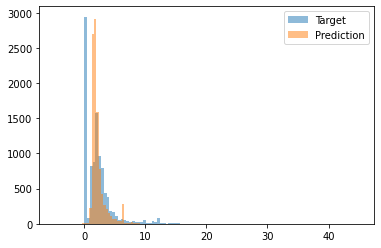

In [4]:
plt.figure()
plt.hist(targets, bins=100, label="Target", alpha=0.5)
plt.hist(predictions, bins=100, label="Prediction", alpha=0.5)
plt.legend()
plt.show()